In [12]:
# --- Imports
import numpy as np
from random import random, seed
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Model imports
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


# --- Settings
np.random.seed(3)
sns.set_theme(style='whitegrid')

In [2]:
def FrankeFunction(x,y): # From excercise description
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [3]:
def plotting_test_values(X, z, z_pred, n):
    """Plots the data in 3D"""
    sort_idx = np.argsort(X[:,0])
    X_sorted = X[sort_idx]
    z_sorted = z[sort_idx]
    z_pred_sorted = z_pred[sort_idx]

    m = int(X.shape[0]/n)
    x = X_sorted[:,0].reshape((m, n))
    y = X_sorted[:,1].reshape((m, n))
    z = z_sorted.reshape((m, n))
    z_pred_plot = z_pred_sorted.reshape((m, n))

    fig = plt.figure(figsize=(12, 6))

    # Plotting the datapoints
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(x, y, z)
    ax.set_title('Franke Function')

    # Plot the polynomial regression prediction (ideally a plane)
    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(x, y, z_pred_plot)
    ax.set_title('Lasso Prediction')

In [64]:
# Making data
n = 100
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
X, Y = np.meshgrid(x,y)
# Unraveling to n^2-arrays
X_flat = X.ravel()
Y_flat = Y.ravel()

k = .01 # noise coefficient
z = FrankeFunction(X_flat,Y_flat) + k*np.random.randn(n**2) # target variable with standard normal noise

In [74]:
p = 5 # highest polynomial degree 
degrees = np.arange(1, p+1) # for looping and plotting later
L = [int((d+1)*(d+2)/2) for d in degrees] # beta lengths
l = L[-1] # greatest beta length

logmin, logmax, m = -4, 1, 6 # logspace start, end, number of lambda values
llambdas = np.logspace(logmin, logmax, m)

beta_values = np.zeros((p, l, m))
MSE_train, MSE_test = np.zeros((p, m)), np.zeros((p, m))
R2_train, R2_test = np.zeros((p, m)), np.zeros((p, m))

X = np.column_stack((X_flat, Y_flat))
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=3)

for deg in degrees:
    for idx, lmbd in enumerate(llambdas):
        # we use pipeline to fit our model
        pipeline = make_pipeline(
            PolynomialFeatures(degree=deg, include_bias=False),
            StandardScaler(),
            Lasso(alpha=lmbd, fit_intercept=True, max_iter=10000))

        pipeline.fit(X_train, z_train)
        z_tilde = pipeline.predict(X_train)
        z_predict = pipeline.predict(X_test)

        MSE_train[deg-1, idx] = mean_squared_error(z_tilde, z_train)
        MSE_test[deg-1, idx] = mean_squared_error(z_predict, z_test)
        R2_train[deg-1, idx] = r2_score(z_train, z_tilde)
        R2_test[deg-1, idx] = r2_score(z_test, z_predict)

        coefs = pipeline.named_steps['lasso'].coef_

        beta_values[deg-1, :len(coefs), idx] = coefs

        #if idx == 1: 
        #    plotting_test_values(X_test, z_test, z_predict, 100)

c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.792e+00, tolerance: 6.613e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.519e+00, tolerance: 6.613e-02
  model = cd_fast.enet_coordinate_descent(


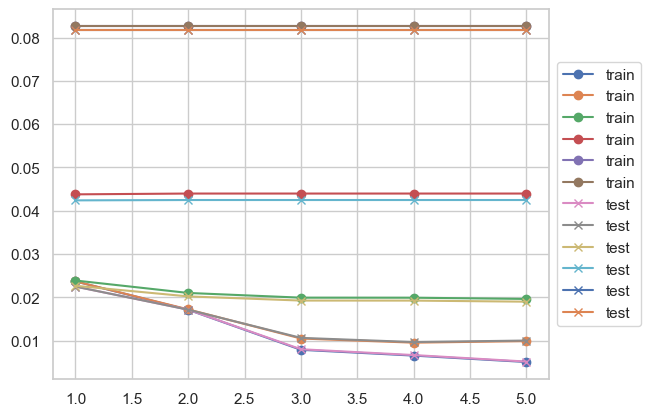

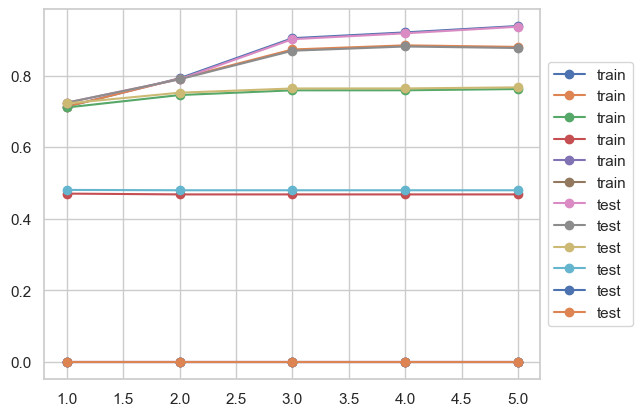

In [75]:
# Plotting MSE and R2 against complexity
plt.plot(degrees, MSE_train, 'o-', label='train')
plt.plot(degrees, MSE_test, 'x-', label='test')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=True)
plt.show()

plt.plot(degrees, R2_train, 'o-', label='train')
plt.plot(degrees, R2_test, 'o-', label='test')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=True)
plt.show()

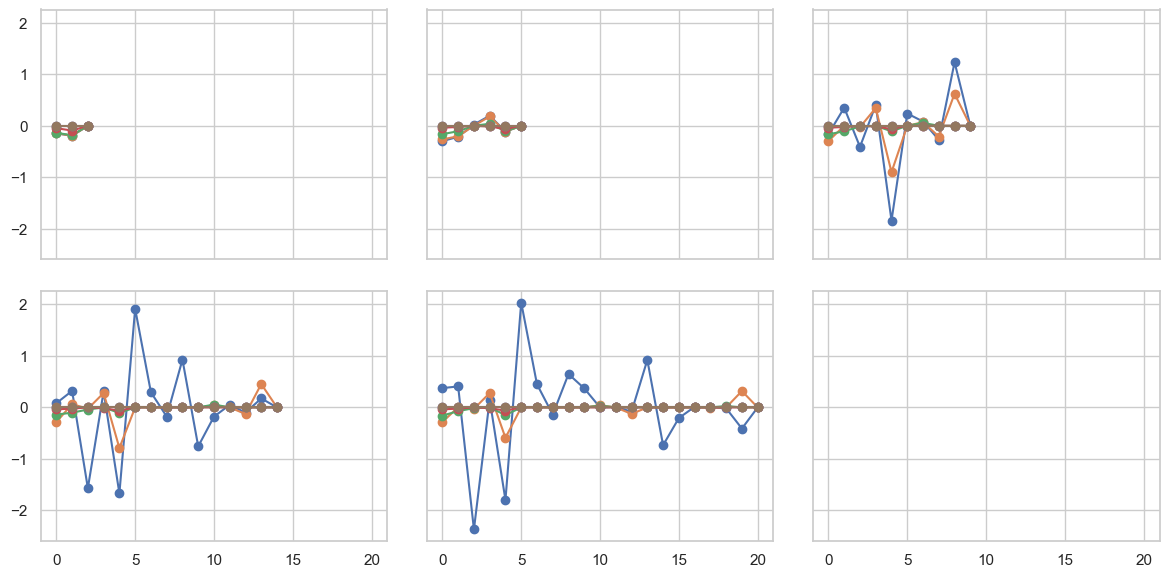

In [76]:
# Plotting all beta coefficients - could be prettier
fig, axs = plt.subplots(2,3, figsize=(12, 6), sharex=True, sharey=True); fig.tight_layout()
axs = axs.flatten()

for i,l in enumerate(L):
    axs[i].plot(np.arange(l), beta_values[i][:l], 'o-')
    # a legend in the first plot with the lambda-values would be nice...
plt.show()

In [62]:
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Define the sizes of polynomial degrees and lambdas
p = 5  # highest polynomial degree
degrees = np.arange(1, p + 1)

# Logspace parameters
logmin, logmax, m = -4, 1, 6
llambdas = np.logspace(logmin, logmax, m)

# Preallocate arrays
L = [(d+1)*(d+2)//2 for d in degrees]  # beta lengths
max_length = L[-1]  # greatest beta length
beta_values = np.zeros((p, max_length, m))
MSE_train, MSE_test = np.zeros((p, m)), np.zeros((p, m))
R2_train, R2_test = np.zeros((p, m)), np.zeros((p, m))

# Create mesh grid and calculate Franke function
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

# Flatten the meshgrid for input into the model
X_flat = X.ravel()
Y_flat = Y.ravel()

def franke_function(x, y):
    term1 = 0.75 * np.exp(-(9*x - 2)**2 / 4.0 - (9*y - 2)**2 / 4.0)
    term2 = 0.75 * np.exp(-(9*x + 1)**2 / 49.0 - (9*y + 1) / 10.0)
    term3 = 0.5 * np.exp(-(9*x - 7)**2 / 4.0 - (9*y - 3)**2 / 4.0)
    term4 = -0.2 * np.exp(-(9*x - 4)**2 - (9*y - 7)**2)
    return term1 + term2 + term3 + term4

z = franke_function(X_flat, Y_flat)

# Combine X_flat and Y_flat into a single feature matrix
features = np.column_stack((X_flat, Y_flat))
X_train, X_test, z_train, z_test = train_test_split(features, z, test_size=0.2, random_state=3)

# Fit models for different degrees and lambda values
for deg in degrees:
    for idx, lmbd in enumerate(llambdas):
        pipeline = make_pipeline(
            PolynomialFeatures(degree=deg, include_bias=False),
            StandardScaler(),
            Lasso(alpha=lmbd, fit_intercept=True, max_iter=10000))

        pipeline.fit(X_train, z_train)
        z_tilde = pipeline.predict(X_train)
        z_predict = pipeline.predict(X_test)

        # Store metrics
        MSE_train[deg-1, idx] = mean_squared_error(z_train, z_tilde)
        MSE_test[deg-1, idx] = mean_squared_error(z_test, z_predict)
        R2_train[deg-1, idx] = r2_score(z_train, z_tilde)
        R2_test[deg-1, idx] = r2_score(z_test, z_predict)

        # Store coefficients
        coefs = pipeline.named_steps['lasso'].coef_
        beta_values[deg-1, :len(coefs), idx] = coefs

# Print results if needed
results = pd.DataFrame({
    'Degree': np.repeat(degrees, m),
    'Lambda': np.tile(llambdas, len(degrees)),
    'MSE_train': MSE_train.ravel(),
    'MSE_test': MSE_test.ravel(),
    'R2_train': R2_train.ravel(),
    'R2_test': R2_test.ravel()
})

print(results)


c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.717e+00, tolerance: 6.603e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\maria\anaconda3\envs\fysstk3155\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.487e+00, tolerance: 6.603e-02
  model = cd_fast.enet_coordinate_descent(


    Degree   Lambda  MSE_train  MSE_test  R2_train   R2_test
0        1   0.0001   0.023583  0.022444  0.714257  0.725026
1        1   0.0010   0.023585  0.022445  0.714233  0.725021
2        1   0.0100   0.023784  0.022628  0.711822  0.722779
3        1   0.1000   0.043685  0.042383  0.470701  0.480744
4        1   1.0000   0.082534  0.081645  0.000000 -0.000263
5        1  10.0000   0.082534  0.081645  0.000000 -0.000263
6        2   0.0001   0.017012  0.017107  0.793879  0.790415
7        2   0.0010   0.017098  0.017097  0.792842  0.790534
8        2   0.0100   0.020899  0.020183  0.746782  0.752725
9        2   0.1000   0.043856  0.042462  0.468635  0.479785
10       2   1.0000   0.082534  0.081645  0.000000 -0.000263
11       2  10.0000   0.082534  0.081645  0.000000 -0.000263
12       3   0.0001   0.007799  0.007957  0.905511  0.902511
13       3   0.0010   0.010405  0.010604  0.873927  0.870081
14       3   0.0100   0.019807  0.019229  0.760010  0.764417
15       3   0.1000   0.